# Learning phase

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *

In [2]:
games_details = pd.read_csv('../dataset/complete_dataset.csv', low_memory=False)
rows_to_drop = games_details[games_details.isin([-1]).any(axis=1)].index
games_details.drop(rows_to_drop, inplace=True)
games_details = games_details.reset_index(drop=True)
games_details.drop(columns=['TEAM_ID'], inplace=True)
games_details.head()

,GAME_ID,PLAYER_ID,FG3M,DATE_DIFF,OPPOSING_TEAM,WINRATE,LOCATION,SEASON
0,22200477,1629641,0.0,3,1610612740,0.333333,Away,2022
1,22200477,1631110,2.0,3,1610612740,0.333333,Away,2022
2,22200477,1627751,0.0,3,1610612740,0.333333,Away,2022
3,22200477,1630170,1.0,3,1610612740,0.333333,Away,2022
4,22200477,1630200,1.0,3,1610612740,0.333333,Away,2022


In [3]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
# label encoder e non one-hot encoding per evitare di aumentare di molto
# dimensionalità del dataset e perché le date e simili hanno effettivamente un ordine

from sklearn.model_selection import KFold, GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error

In [4]:
games_details = games_details.drop(columns=['GAME_ID'])
games_details = games_details.sample(frac=0.1)

categorical_columns = games_details.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()
games_details[list(categorical_columns)] = games_details[list(categorical_columns)].apply(label_encoder.fit_transform)

games_details = games_details.dropna()
games_details = games_details.reset_index(drop=True)

X = games_details.loc[:, games_details.columns != 'FG3M']
y = games_details['FG3M']

reg_metrics = pd.DataFrame(columns=['Model', 'MAE', 'MSE'])

In [5]:
num_folds = 8
n_jobs = -1

num_features = X.shape[1]
p = int(np.ceil(num_features / 3))
rf_param_grid = {
    'n_estimators': [50, 100, 500],
    'max_features': ['sqrt', 'log2', p] 
}

rf_regressor = RandomForestRegressor(n_jobs=n_jobs)
scaler1 = StandardScaler()
X_scaled = scaler1.fit_transform(X) # questo non sarebbe legittimo

grid_search = GridSearchCV(rf_regressor, rf_param_grid, cv=num_folds, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

rf_best_params = grid_search.best_params_
print(rf_best_params)

{'max_features': 2, 'n_estimators': 500}


In [6]:
rf_kfolds = KFold(n_splits=num_folds, shuffle=True)
gini_importances = pd.DataFrame(columns=X.columns)

for fold, (train_idx, test_idx) in enumerate(rf_kfolds.split(X)):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    rf_regressor = RandomForestRegressor(n_estimators = rf_best_params['n_estimators'], max_features = rf_best_params['max_features'], n_jobs=n_jobs)
    
    rf_regressor.fit(X_train, y_train)
    
    y_pred = rf_regressor.predict(X_test)
    
    current_rf_mae = mean_absolute_error(y_test, y_pred)
    current_rf_mse = mean_squared_error(y_test, y_pred)
    
    reg_metrics.loc[len(reg_metrics)] = ['RF', current_rf_mae, current_rf_mse]

    importances = rf_regressor.feature_importances_
    gini_importances.loc[fold] = importances

In [7]:
dummy_kfolds = KFold(n_splits=num_folds, shuffle=True)

for train_idx, test_idx in dummy_kfolds.split(X):
    
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    dummy_regressor = DummyRegressor()
    dummy_regressor.fit(X_train, y_train)
    
    y_dummy_pred = dummy_regressor.predict(X_test)

    current_dummy_mae = mean_absolute_error(y_test, y_dummy_pred)
    current_dummy_mse = mean_squared_error(y_test, y_dummy_pred)

    reg_metrics.loc[len(reg_metrics)] = ['DUMMY', current_dummy_mae, current_dummy_mse]

In [8]:
knn_param_grid = {
    'n_neighbors': [1, 5, 10],
    'p': [1, 2]
}

knn_regressor = KNeighborsRegressor()

grid_search = GridSearchCV(knn_regressor, knn_param_grid, cv=num_folds, scoring='neg_mean_squared_error')
grid_search.fit(X_scaled, y)

knn_best_params = grid_search.best_params_
print(knn_best_params)

{'n_neighbors': 10, 'p': 1}


In [9]:
knn_kfolds = KFold(n_splits=num_folds, shuffle=True)

for train_idx, test_idx in knn_kfolds.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    knn_regressor = KNeighborsRegressor(n_neighbors = knn_best_params['n_neighbors'], p = knn_best_params['p'])
    knn_regressor.fit(X_train, y_train)
    
    y_pred = knn_regressor.predict(X_test)
    
    current_knn_mae = mean_absolute_error(y_test, y_pred)
    current_knn_mse = mean_squared_error(y_test, y_pred)
    
    reg_metrics.loc[len(reg_metrics)] = ['KNN', current_knn_mae, current_knn_mse]

    Model       MAE       MSE
0      RF  0.877467  1.413662
1      RF  0.897588  1.461861
2      RF  0.876029  1.385230
3      RF  0.893317  1.494601
4      RF  0.890991  1.493617
5      RF  0.884917  1.440566
6      RF  0.894775  1.443236
7      RF  0.892067  1.475757
8   DUMMY  0.940570  1.527887
9   DUMMY  0.934124  1.517753
10  DUMMY  0.934994  1.489902
11  DUMMY  0.941628  1.551209
12  DUMMY  0.936211  1.522047
13  DUMMY  0.934185  1.515372
14  DUMMY  0.920330  1.438071
15  DUMMY  0.914945  1.423109
16    KNN  0.942202  1.623924
17    KNN  0.939338  1.597697
18    KNN  0.942288  1.614220
19    KNN  0.929228  1.555354
20    KNN  0.931051  1.574973
21    KNN  0.922100  1.534871
22    KNN  0.926898  1.553615
23    KNN  0.937038  1.601848


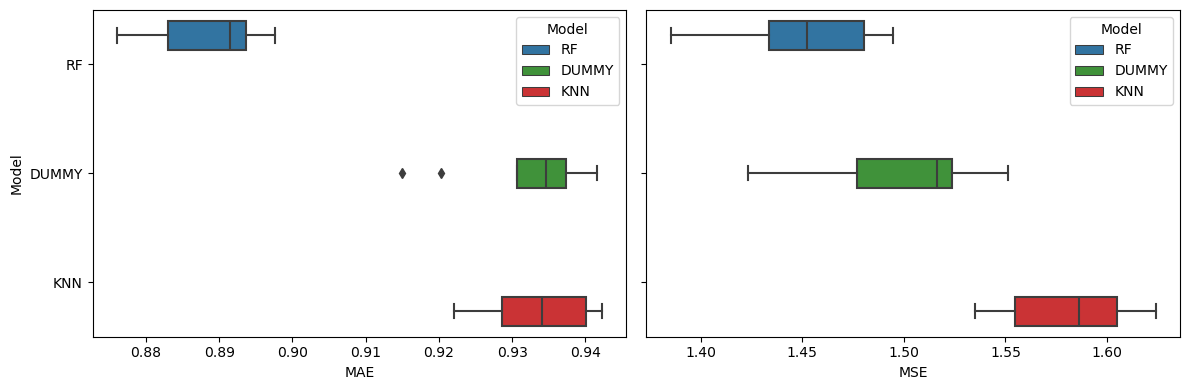

In [10]:
print(reg_metrics)
fig, axs = plt.subplots(1, 2, figsize= (12, 4))
sns.boxplot(data=reg_metrics, x="MAE", y="Model", hue = 'Model', ax=axs[0], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics, x="MSE", y="Model", hue = 'Model', ax=axs[1], palette=sns.color_palette('Paired')[1::2])
axs[1].set_yticklabels('')
axs[1].set_ylabel('')
plt.tight_layout()
plt.show()

   PLAYER_ID  DATE_DIFF  OPPOSING_TEAM   WINRATE  LOCATION    SEASON
0   0.498678   0.087340       0.221295  0.047290  0.026540  0.118857
1   0.497553   0.088581       0.222352  0.046011  0.026319  0.119184
2   0.496121   0.088261       0.219781  0.048900  0.027768  0.119168
3   0.498461   0.088644       0.220045  0.047029  0.026010  0.119810
4   0.495160   0.088700       0.220591  0.044872  0.027712  0.122965
5   0.499182   0.088456       0.219823  0.046400  0.026106  0.120033
6   0.496968   0.088984       0.221712  0.045601  0.026706  0.120029
7   0.494256   0.088894       0.222970  0.045774  0.028322  0.119784


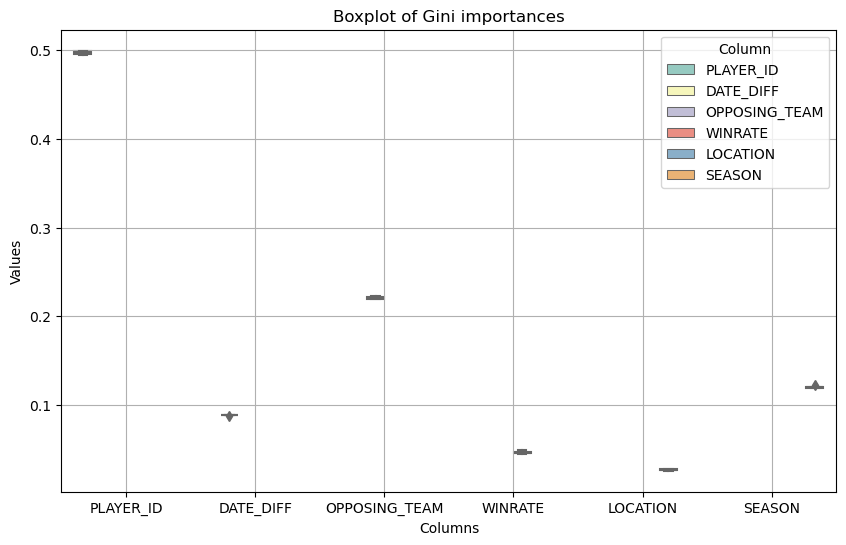

In [11]:
print(gini_importances)
melted_gini = gini_importances.melt(var_name='Column')

# Create boxplot with seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Column', y='value', data=melted_gini, hue='Column', palette='Set3')

plt.title('Boxplot of Gini importances')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.legend(title='Column')
plt.grid(True)
plt.show()